In [1]:
from src.config import config
from src.models import MPCTransformer
from src.train import create_train_state
from flax.training import checkpoints
import jax

/home/jannik/miniconda3/lib/python3.10/site-packages/jax/_src/api_util.py:190: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
2023-05-03 15:23:20.853450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = MPCTransformer(**config['model'])

In [3]:
init_rng = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}
state = create_train_state(model, 
                             init_rng, 
                             config['training']['learning_rate'], 
                             config['training']['momentum'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
CKPT_DIR = '../checkpoints/map/'
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

In [38]:
import numpy as np
%config InlineBackend.figure_formats = ['svg']

data = np.load('../data/obstacles_test_scenario.npz')

color_images = data['color_images']
depth_images = data['depth_images']
maps = data['maps']
cmd_vels = data['cmd_vels']

<Figure size 640x480 with 0 Axes>

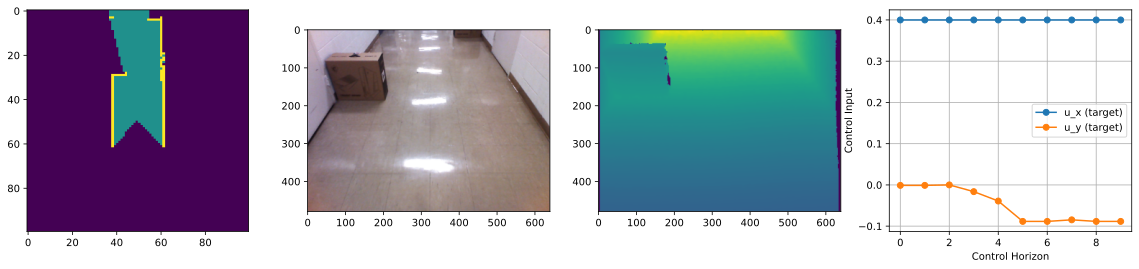

In [72]:
idx = 45

input = maps[idx]
input = np.expand_dims(input, axis=0)
target = cmd_vels[idx:idx+config['model']['solver']['horizon']]
pred = model.apply({'params': state.params}, input, train=False)

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

plt.figure(figsize=(20,4))

plt.subplot(1, 4, 1)
plt.imshow(np.transpose(np.flip(input[0][:,:,0])), interpolation='nearest')

plt.subplot(1, 4, 2)
plt.imshow(color_images[idx])

plt.subplot(1, 4, 3)
plt.imshow(depth_images[idx])

plt.subplot(1, 4, 4)
plt.plot(target[:,:2], 'o-', label=['u_x (target)','u_y (target)'])
plt.grid()
plt.xlabel('Control Horizon')
plt.ylabel('Control Input')
plt.legend()


# plt.show()
# plt.plot(target[:,:2], label=['u_x (target)','u_y (target)'])
# # plt.plot(pred[0][:,:2], label=['u_x (pred)','u_y (pred)'])
# plt.legend()
# plt.show()